In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import pickle as pkl

plt.style.use('default')
sns.set_palette("husl")

MAX_EPOCHS = 4959
RESULTS_DIR = "8_18_training_burgers"
HYPERPARAMS = ["share", "inner_wrap", "train_kind"]

def load_hyperparameter_data(results_dir):
    results_path = Path(results_dir)
    all_data = []

    print(f"Searching for progress.csv files in: {results_path.absolute()}")
    progress_files = list(results_path.rglob("progress.csv"))
    print(f"Found {len(progress_files)} progress.csv files")

    for progress_file in progress_files:
        try:
            df = pd.read_csv(progress_file)
            params_file = progress_file.parent / "params.pkl"
            with open(params_file, 'rb') as f:
                params = pkl.load(f)

            for key, value in params.items():
                if isinstance(value, (list, dict, tuple)):
                    df[key] = str(value)
                else:
                    df[key] = value

            print(f"Loaded hyperparameters from {params_file}")

            df['file_path'] = str(progress_file)
            all_data.append(df)

        except Exception as e:
            print(f"Error loading {progress_file}: {e}")
    
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"Combined dataframe shape: {combined_df.shape}")
        print(f"All columns: {list(combined_df.columns)}")

        if 'epoch' in combined_df.columns:
            combined_df = combined_df[combined_df['epoch'] <= MAX_EPOCHS]

        return combined_df
    else:
        return pd.DataFrame()

print(f"Loading hyperparameter data from {RESULTS_DIR}...")
df = load_hyperparameter_data(RESULTS_DIR)

if not df.empty:
    print(f"\n✅ SUCCESS: Loaded {len(df)} rows from {df['file_path'].nunique()} runs")
    print(f"Available hyperparameters: {[col for col in HYPERPARAMS if col in df.columns]}")
    print(f"Epoch range: {df['epoch'].min()}-{df['epoch'].max()}")
    print(f"Key columns present: {['val_loss' in df.columns, 'train_loss' in df.columns, 'epoch' in df.columns]}")

    run_completion = df.groupby('file_path')['epoch'].max().reset_index()
    run_completion.columns = ['file_path', 'final_epoch']

    print(f"\n📊 TRAINING COMPLETION SUMMARY:")
    print(f"• Total runs: {len(run_completion)}")
    print(f"• Expected epochs: {MAX_EPOCHS}")
    print(f"• Completed runs: {len(run_completion[run_completion['final_epoch'] >= MAX_EPOCHS])}")
    print(f"• Average epochs: {run_completion['final_epoch'].mean():.1f}")
    print(f"• Epoch range: {run_completion['final_epoch'].min()}-{run_completion['final_epoch'].max()}")
else:
    print("❌ ERROR: No data found!")

Loading hyperparameter data from 8_18_training_burgers...
Searching for progress.csv files in: /lambda/nfs/hyperparam/anie-experiments/8_18_training_burgers
Found 12 progress.csv files
Loaded hyperparameters from 8_18_training_burgers/train_fn_2025-08-19_07-01-52/train_fn_62703_00000_0_inner_wrap=True,share=True,train_kind=one_step_2025-08-19_07-01-52/params.pkl
Loaded hyperparameters from 8_18_training_burgers/train_fn_2025-08-19_07-01-52/train_fn_62703_00001_1_inner_wrap=False,share=True,train_kind=one_step_2025-08-19_07-01-52/params.pkl
Loaded hyperparameters from 8_18_training_burgers/train_fn_2025-08-19_07-01-52/train_fn_62703_00002_2_inner_wrap=True,share=False,train_kind=one_step_2025-08-19_07-01-52/params.pkl
Loaded hyperparameters from 8_18_training_burgers/train_fn_2025-08-19_07-01-52/train_fn_62703_00003_3_inner_wrap=False,share=False,train_kind=one_step_2025-08-19_07-01-52/params.pkl
Loaded hyperparameters from 8_18_training_burgers/train_fn_2025-08-19_06-01-12/train_fn_e8a

In [ ]:
def analyze_best_runs(df, n_best=10):
    if df.empty:
        print("❌ No data available for analysis!")
        return pd.DataFrame()
    
    if 'val_loss' not in df.columns:
        print(f"❌ ERROR: 'val_loss' column not found!")
        print(f"Available columns: {list(df.columns)}")
        return pd.DataFrame()
    
    if 'file_path' not in df.columns:
        print(f"❌ ERROR: 'file_path' column not found!")
        return pd.DataFrame()
    
    final_metrics = df.groupby('file_path')['val_loss'].min().sort_values()
    best_runs = final_metrics.head(n_best)
    
    results = []
    
    for idx, (file_path, final_val_loss) in enumerate(best_runs.items()):
        run_data = df[df['file_path'] == file_path].iloc[0]
        
        config = {'rank': idx + 1, 'final_val_loss': final_val_loss}
        for param in HYPERPARAMS:
            config[param] = run_data.get(param, 'N/A')
        
        results.append(config)
        
        for param in HYPERPARAMS:
            param_display = param.replace('_', '-')
    
    results_df = pd.DataFrame(results)
    
    top_5 = results_df.head(5)
    for param in HYPERPARAMS:
        if param in top_5.columns:
            mode_val = top_5[param].mode()
            if not mode_val.empty:
                param_display = param.replace('_', '-')
    
    print(f"\n📊 SUMMARY TABLE - TOP {min(n_best, len(results_df))} CONFIGURATIONS:")
    print("=" * 100)
    display_cols = ['rank', 'final_val_loss'] + HYPERPARAMS
    summary_table = results_df[display_cols].copy()
    summary_table.columns = ['#', 'Val Loss'] + [col.replace('_', '-').title() for col in HYPERPARAMS]
    print(summary_table.to_string(index=False, float_format='%.6f'))
    
    print(f"\nAverage Val Loss by Hyperparameter (top 100% runs by hyperparameter):")
    print("=" * 80)
    
    for param in HYPERPARAMS:
        if param in df.columns and not df[param].isna().all():
            param_performance = (
                df.groupby(['file_path', param])['val_loss']
                .min()
                .reset_index()
                .groupby(param)['val_loss']
                .apply(lambda x: x.nsmallest(int(len(x) * 1.0)).mean())
                .sort_values()
            )
            param_display = param.replace('_', '-')
            print(f"\n  📊 {param_display.upper()}:")
            for value, avg_perf in param_performance.items():
                print(f"      • {value:15}: {avg_perf:.6f}")
    return results_df

def create_comprehensive_plots(df, n_best=5):
    if df.empty:
        print("❌ No data available for plotting!")
        return
    
    required_cols = ['val_loss', 'train_loss', 'epoch', 'file_path']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"❌ ERROR: Missing required columns: {missing_cols}")
        print(f"Available columns: {list(df.columns)}")
        return
    
    final_metrics = df.groupby('file_path')['val_loss'].min().sort_values()
    best_runs = final_metrics.head(n_best)
    
    fig, axes = plt.subplots(2, figsize=(20, 16))
    colors = plt.cm.Set1(np.linspace(0, 1, len(best_runs)))
    
    for idx, (file_path, final_val) in enumerate(best_runs.items()):
        run_data = df[df['file_path'] == file_path].sort_values('epoch')
        color = colors[idx]
        
        params = []
        for param in HYPERPARAMS:
            if param in run_data.columns and not run_data[param].isna().all():
                short_name = param.replace('_kind', '').replace('_', '-')[:15]
                params.append(f"{short_name}={run_data[param].iloc[0]}")
        
        label = f"#{idx+1}: {' | '.join(params[:5])}"
        
        axes[0].plot(run_data['epoch'], run_data['train_loss'], color=color, label=label, alpha=0.8, linewidth=2)
        axes[1].plot(run_data['epoch'], run_data['val_loss'], color=color, label=label, alpha=0.8, linewidth=2)
    
    axes[0].set_title(f'Training Loss - Top {n_best} Runs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Training Loss')
    axes[0].set_yscale('log')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(fontsize=9)
    
    axes[1].set_title(f'Validation Loss - Top {n_best} Runs')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Validation Loss')
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(fontsize=9)


📊 SUMMARY TABLE - TOP 12 CONFIGURATIONS:
 #  Val Loss  Share  Inner-Wrap Train-Kind
 1  0.000274   True       False    acausal
 2  0.000327   True        True    acausal
 3  0.000338   True       False   generate
 4  0.000349  False        True    acausal
 5  0.000404  False       False   generate
 6  0.000426  False       False    acausal
 7  0.000433  False        True   generate
 8  0.000449   True        True   generate
 9  0.001077  False        True   one_step
10  0.001108   True        True   one_step
11  0.001202   True       False   one_step
12  0.001285  False       False   one_step

Average Val Loss by Hyperparameter (top 100% runs by hyperparameter):

  📊 SHARE:
      •               1: 0.000616
      •               0: 0.000662

  📊 INNER-WRAP:
      •               1: 0.000624
      •               0: 0.000655

  📊 TRAIN-KIND:
      • acausal        : 0.000344
      • generate       : 0.000406
      • one_step       : 0.001168


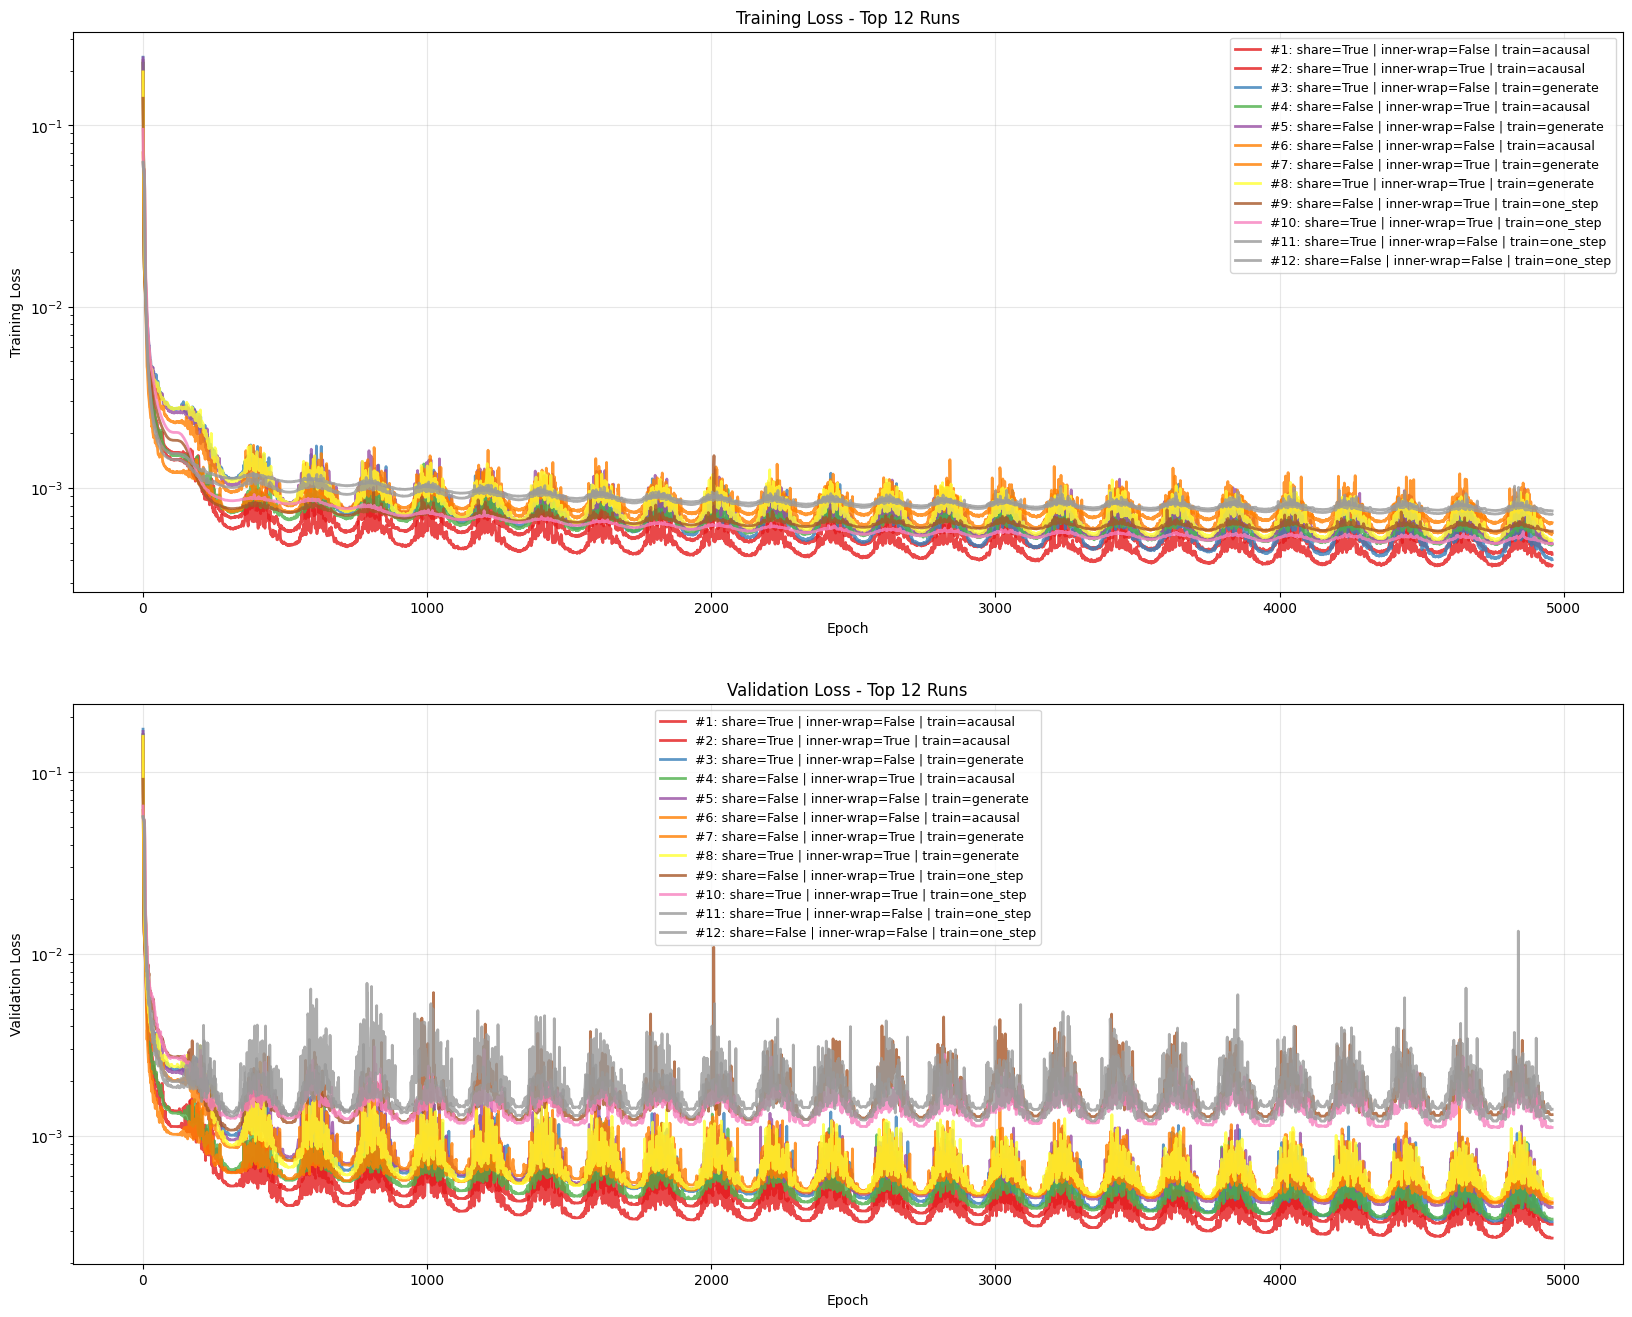

In [3]:
try:
    best_runs_df = analyze_best_runs(df, n_best=12)
except Exception as e:
    print(f"❌ Error during best runs analysis: {e}")
    best_runs_df = pd.DataFrame()

try:
    create_comprehensive_plots(df, n_best=12)
except Exception as e:
    print(f"❌ Error during visualization: {e}")
    print("Skipping plots...")